# 17 - Working with DLIS Files Using DLISIO

### Andy McDonald
**Link to Article:**

Click on the button below to run this notebook on binder without needing to download it or install any libraries.  
Please note that the interactive widgets will not work on Binder or when viewing the notebook on GitHub.  
**Binder:**

## Introduction
There are a number of different formats that well log and petrophysical data can be stored in. In the earlier articles and notebooks of this series, we have mainly focused on loading data from CSV files ([here](https://github.com/andymcdgeo/Petrophysics-Python-Series/blob/master/01%20-%20Loading%20and%20Displaying%20Well%20Data%20From%20CSV.ipynb)) and LAS files ([here](https://towardsdatascience.com/loading-multiple-well-log-las-files-using-python-39ac35de99dd) and [here](https://andymcdonaldgeo.medium.com/loading-and-displaying-well-log-data-b9568efd1d8)). Even though LAS files are one of the common formats, they have a flat structure with a header section containing meta data about the well and the file followed by a series of columns containing values for each logging curve. As they are flat, they can't easily store array data. It is possible, but they individual elements of the array are split out into individual columns/curves within a LAS file as opposed to a single array. This is where DLIS files come in.

Within this article, we will cover:
- the basics of loading a DLIS file
- exploring the contents and parameters within a DLIS file
- displaying processed acoustic waveform data

We will not be covering acoustic waveform processing. Just the display of previously processed data.

This article was inspired by the work of Erlend M. Viggen (https://erlend-viggen.no/dlis-files/) who has created an excellent Jupyter Notebook which goes into more detail about working with DLIS files.  

### DLIS Files
Digital Log Interchange Standard (DLIS) files are structured binary files that contain data tables for well information and well logging data. The file format was developed in the late 1980's by Schlumberger and subsequently published in 1991 by the American Petroleum Institute to create a standardised well log data format. Full details of the standard format can be found [here.](http://w3.energistics.org/rp66/v1/Toc/main.html). The DLIS file format can often be difficult and awkward to work with at times due to the format being developed nearly 30 years ago, and different software packages and vendors can create their own flavours of DLIS by adding in new structures and object-types.

DLIS files contain large amounts of metadata associated with the well and data. These sections do not contain the well data, these are stored within Frames, of which there can be many representing different logging passes/runs or processing stages (e.g. Raw or Interpreted).  Frames are table objects which contain the well log data, where each column represents a logging curve, and that data is indexed by time or depth. Each logging curve within the frame is referred to as a channel. The channels can be a single dimension or multi-dimensional

### dlisio
dlsio is a python library that has been developed by Equinor ASA to read DLIS files and Log Information Standard79 (LIS79) files. Details of the library can be found [here](https://dlisio.readthedocs.io/en/stable/index.html).

### Data
The data used within this article was sourced from the [NLOG: Dutch Oil and Gas Portal](https://www.nlog.nl/en/welcome-nlog).

**Privacy Notice:** DLIS files can contain information that can identify individuals that were involved in the logging operations. To protect their identity from appearing in search engine results without their excplicit consent, these fields have been hidden in this article/notebook.


## Library Imports 
The first step with any project is to load in the libraries that we want to use. For this notebook we will be using [NumPy](https://numpy.org) for working with arrays, [pandas](https://pandas.pydata.org) for storing data, and [matplotlib](https://matplotlib.org) for displaying the data. To load the data, we will be using the [dlisio](https://github.com/equinor/dlisio) library. 

Also, as we will be working with dataframes to view parameters, which can be numerous, we need to change the maximum number of rows that will be displayed when that dataframe is called. This is achieved by `pd.set_option('display.max_rows', 500)`.

In [12]:
from dlisio import dlis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno


pd.set_option('display.max_rows', 500)

In [13]:
import dlisio
dlisio.__version__

'1.0.3'

## Loading a DLIS File

As we are working with a single DLIS file, we can use the following code to load the file. A physical DLIS file can contain multiple logical files, therefore, using this syntax allows the first file to be output to `f` and any subsequent logical files placed into `tail`.

In [14]:
f, *tail = dlis.load('Data/NLOG_LIS_LAS_7857_FMS_DSI_MAIN_LOG.DLIS')

We can see the contents of each of these by calling upon their names. If we call upon `f`, we can see that it returns a `LogicalFile(00001_AC_WORK` and if we call upon `tail`, we get a blank list, which lets us know that there are no other logical files within the DLIS.

In [15]:
print(f)
print(tail)

LogicalFile(FMS_DSI_138PUP)
[]


To view the high level contents of the file we can use the `.describe()` method. This returns information about the number of frames, channels and objects within the Logical File. When we apply this to `f` we can see we have a file with 4 frames and 484 channels (logging curves), in addition to a number of known and unknown objects. 

In [16]:
f.describe()


------------
Logical File
------------
Description : LogicalFile(FMS_DSI_138PUP)
Frames      : 4
Channels    : 484

Known objects
--
CALIBRATION-MEASUREMENT : 22
EQUIPMENT               : 27
AXIS                    : 50
FILE-HEADER             : 1
CALIBRATION-COEFFICIENT : 12
CALIBRATION             : 341
CHANNEL                 : 484
PROCESS                 : 3
ORIGIN                  : 1
FRAME                   : 4
TOOL                    : 5
PARAMETER               : 480

Unknown objects
--
440-CHANNEL                  : 538
440-OP-CHANNEL               : 573
440-PRESENTATION-DESCRIPTION : 1


In [17]:
for ch in f.channels:
    print(f"{f.mnemonic} | {f.unit} | {f.description} | Origin: {f.origin.id}")


AttributeError: 'LogicalFile' object has no attribute 'mnemonic'

## Viewing the File's Metadata

### Data Origin

The first set of metadata we will look at is the origin. This provides information about the source of the data within the file. Occassionally, data may originate from multiple sources so we need to account for this by unpacking the origins into two variables. We can always check if there is other origin information by printing the length of the list.

In [ ]:
origin, *origin_tail = f.origins
print(len(origin_tail))

0


In [ ]:
print(origin)
print(origin_tail)

Origin(DLIS_DEFINING_ORIGIN)
[]


For this article, we will focus on `origin`. We can view the details of it, by calling upon `describe()`. This provides details about the field, well, and other file information.

In [ ]:
origin.describe()

------
Origin
------
name   : DLIS_DEFINING_ORIGIN
origin : 41
copy   : 0

Logical file ID          : FMS_DSI_138PUP
File set name and number : WINTERSHALL/L5-9 / 41
File number and type     : 170 / PLAYBACK

Field                   : L5
Well (id/name)          :  / L5-9
Produced by (code/name) : 440 / Schlumberger
Produced for            : Wintershall Noordzee B.V.
Run number              : -1
Descent number          : -1
Created                 : 2002-02-17 18:18:52

Created by              : OP, (version: 9C2-303)
Other programs/services : MESTB: Micro Electrical Scanner - B (Slim)  SGTL:
                          Scintillation Gamma-Ray - L           DTAA: Downhole
                          Toolbus Adapter - A          DSSTB: Dipole Shear
                          Imager - B              DTCA: DTS Telemetry Cartridge
                          ACTS: Auxiliary Compression Tension Sub - B DIP: Dip
                          Computation                        DIR: Directional
          

### Frames

Frames within a DLIS file can represent different logging passes or different stages of data, such as raw well log measurements to pertophysical interpretations or processed data. Each frame has a number of properties. The example code below prints out the properties in an easy-to-read format.

In [ ]:
f.frames

[Frame(60B), Frame(10B), Frame(1B), Frame(15B)]

In [ ]:
for frame in f.frames:
    
    # Search through the channels for the index and obtain the units
    for channel in frame.channels:
        if channel.name == frame.index:
            depth_units = channel.units
    
    print(f'Frame Name: \t\t {frame.name}')
    print(f'Index Type: \t\t {frame.index_type}')
    print(f'Depth Interval: \t {frame.index_min} - {frame.index_max} {depth_units}')
    print(f'Depth Spacing: \t\t {frame.spacing} {depth_units}')
    print(f'Direction: \t\t {frame.direction}')
    print(f'Num of Channels: \t {len(frame.channels)}')
    print(f'Channel Names: \t\t {str(frame.channels)}')

    print('\n------------------------------------------')

Frame Name: 		 60B
Index Type: 		 BOREHOLE-DEPTH
Depth Interval: 	 0 - 0 0.1 in
Depth Spacing: 		 -60 0.1 in
Direction: 		 DECREASING
Num of Channels: 	 77
Channel Names: 		 [Channel(TDEP), Channel(BS), Channel(CS), Channel(TENS), Channel(ETIM), Channel(DEVI), Channel(P1AZ_MEST), Channel(ANOR), Channel(FINC), Channel(HAZI), Channel(P1AZ), Channel(RB), Channel(SDEV), Channel(GAT), Channel(GMT), Channel(ECGR), Channel(ITT), Channel(SPHI), Channel(DCI2), Channel(DCI4), Channel(SOBS), Channel(DTCO), Channel(DTSM), Channel(PR), Channel(VPVS), Channel(CHR2), Channel(DT2R), Channel(DTRP), Channel(CHRP), Channel(DTRS), Channel(CHRS), Channel(DTTP), Channel(CHTP), Channel(DTTS), Channel(CHTS), Channel(DT2), Channel(DT4P), Channel(DT4S), Channel(SPCF), Channel(DPTR), Channel(DPAZ), Channel(QUAF), Channel(DDIP), Channel(DDA), Channel(FCD), Channel(HDAR), Channel(RGR), Channel(TIME), Channel(CVEL), Channel(MSW1), Channel(MSW2), Channel(FNOR), Channel(SAS2), Channel(SAS4), Channel(PWF2), Channel(PW

This returns the following summary. Which indicates that two frames exist within this file. With the first frame containing basic well log curves of bitsize (BIT), caliper (CAL), gamma ray (GR) and tension (TEN). The second frame contains the post-processed acoustic waveform data.

### Parameters within the DLIS File
As seen earlier, we have a number of objects associated with the DLIS file. To make them easier to read we can create a short function that creates a pandas dataframe containing the parameters.

In [ ]:
def summary_dataframe(object, **kwargs):
    # Create an empty dataframe
    df = pd.DataFrame()
    
    # Iterate over each of the keyword arguments
    for i, (key, value) in enumerate(kwargs.items()):
        list_of_values = []
        
        # Iterate over each parameter and get the relevant key
        for item in object:
            # Account for any missing values.
            try:
                x = getattr(item, key)
                list_of_values.append(x)
            except:
                list_of_values.append('')
                continue
        
        # Add a new column to our data frame
        df[value]=list_of_values
    
    # Sort the dataframe by column 1 and return it
    return df.sort_values(df.columns[0])
    

The parameters can be accessed by calling upon `f.parameters`. To access the parameters, we can use the attributes `name`, `long_name` and `values` and pass these into the summary function.

This returns a long table of each of the parameters. The example below is a small section of that table. From it, we can see parameters such as bottom log interval, borehole salinity and bottom hole temperature.

In [ ]:
param_df = summary_dataframe(f.parameters, name='Name', long_name='Long Name', values='Value')

# Hiding people's names that may be in parameters.
# These two lines can be commented out to show them
mask = param_df['Name'].isin(['R8', 'RR1', 'WITN', 'ENGI'])
param_df = param_df[~mask]

param_df

,Name,Long Name,Value
48,ACCC,Accelerometer coefficients,"[[0.0, 0.00039999998989515007, -0.000899999984..."
53,ACCM,Accelerometer Month of Calibration,[8]
58,ACCN,Accelerometer Serial Number,[179]
51,ACCT,Accelerometer Type (Manufacturer Code),[0]
56,ACCY,Accelerometer Year of Calibration,[86]
60,ACPP,Accelerometer PROM Presence,[PRESENT]
72,AFMO,Accelerometer Filtering Mode,[HAMMING]
0,ALTDPCHAN,Name of alternate depth channel,[SPEEDCORRECTEDDEPTH]
317,AMD,Azimuth of Maximum Deviation,[]
369,APD,Above Permanent Datum,[39.5]


### Channels

The channels within a frame are the individual curves or arrays. To view a quick summary of these, we can pass in a number of attributes to the `summary_dataframe()` method.

In [ ]:
channels = summary_dataframe(f.channels, name='Name', long_name='Long Name', dimension='Dimension', units='Units', frame='Frame')
channels

,Name,Long Name,Dimension,Units,Frame
329,ABS,Area of Bit,[1],m2,Frame(60B)
328,AFCD,Area of Future Casing,[1],m2,Frame(60B)
38,ANOR,Acceleration Computed Norm,[1],m/s2,Frame(60B)
461,ANOR_SL,Acceleration Computed Norm,[1],m/s2,None
327,AREA,Area of Borehole,[1],m2,Frame(60B)
443,AX,X Acceleration,[1],m/s2,Frame(15B)
468,AX_SL,X Acceleration,[1],m/s2,None
444,AY,Y Acceleration,[1],m/s2,Frame(15B)
469,AY_SL,Y Acceleration,[1],m/s2,None
445,AZ,Z Acceleration,[1],m/s2,Frame(15B)


### Tools 
The tools object within the DLIS file contains information relating to the tools that were used to acquire the data. We can get a summary of the tools available be calling upon the `summary_dataframe` method.

In [ ]:
f.tools

[Tool(MESTB), Tool(SGTL), Tool(DTAA), Tool(DSSTB), Tool(DTCA)]

In [ ]:
tools = summary_dataframe(f.tools, name='Name', description='Description')
tools

,Name,Description
3,DSSTB,Dipole Shear Imager - B
2,DTAA,Downhole Toolbus Adapter - A
4,DTCA,DTS Telemetry Cartridge
0,MESTB,Micro Electrical Scanner - B (Slim)
1,SGTL,Scintillation Gamma-Ray - L


As we are looking to plot acoustic waveform data, we can look at the parameters for the DSSTB - Dipole Shear Imager tool. First, we need to grab the object from the dlis and then pass it into the `summary_dataframe` function.

From the returned table, we can view each of the parameters that relate to the tool and the processing of the data.

In [ ]:
dsstb = f.object('TOOL', 'DSSTB')
dsstb_params = summary_dataframe(dsstb.parameters, name='Name', long_name='Long Name', values='Values')
dsstb_params

,Name,Long Name,Values
33,BARS_MTR1,Length for Monopole Transmitter to Receiver 1,[2.7432000637054443]
6,BHS,Borehole Status,[OPEN]
1,BHT,Bottom Hole Temperature (used in calculations),[160.0]
18,BILI,Bond Index Level for Zone Isolation,[0.800000011920929]
213,CASF,Label Casing Function - Monopole P&S,[50.0]
10,CDTS,C-Delta-T Shale,[100.0]
206,COLL,Label Slowness Lower Limit - Monopole P&S Comp...,[40.0]
207,COUL,Label Slowness Upper Limit - Monopole P&S Comp...,[180.0]
17,CSTR,Compressive Strength of Cement,[0.0]
114,DCL1,STC DC Lower Limit - Lower Dipole,[0.0]


## Working With Data Objects
Now that some of the meta data has been explored, we can now attempt to access the data stored within the file.

Frames and data can be accessed by calling upon the `.object()` for the file. First, we can assign the frames to variables, which will make things easier when accessing the data within them, especially if the frames contain channels/curves with the same name. The `.object()` method requires the type of the object being accessed, i.e. 'FRAME' or 'CHANNEL' and its name. In this case we can refer back to the previous step which contains the channels and the frame names. We can see that the basic logging curves are in one frame and the acoustic data is in another.

In [ ]:
frame1 = f.object('FRAME','60B')
frame1

Frame(60B)

We can also directly access the channels for a specific curve. However, this can cause confusion when working with frames containing channels/curves with the same name. 

The example below shows how to call key properties of the channel/curve. Details of which can be found [here.](https://dlisio.readthedocs.io/en/stable/dlis/api.html#dlisio.dlis.Channel)

In [ ]:
dtc = f.object('CHANNEL', 'PWF4')

# Print out the properties of the channel/curve
print(f'Name: \t\t{dtc.name}')
print(f'Long Name: \t{dtc.long_name}')
print(f'Units: \t\t{dtc.units}')
print(f'Dimension: \t{dtc.dimension}') #if >1, then data is an array

Name: 		PWF4
Long Name: 	DSST Packed Waveform Data - Monopole P&S
Units: 		
Dimension: 	[8, 512]


### Plotting Data
Now that we know how to access the frames and channels of the DLIS file, we can now assign variable names to the curves that we are looking to plot. In this article, we will be plotting:

- DTCO: Delta-T Compressional
- DTSM: Delta-T Shear
- SPR4: STC Slowness Projection, Receiver Array - Monopole P&S
- PWF4: DSST Packed Waveform Data - Monopole P&S

We will also need to assign a depth curve (TDEP) from the frame. Looking back at the information section of the frame, the `Depth Interval` is 0.1 inches. This needs to be converted to metres by multiplying by 0.00254.

In [23]:
curves = frame1.curves()

depth = curves['TDEP'] * 0.00254

dtco = curves['DTCO']
dtsm = curves['DTSM']
stc_mono = curves['SPR4']
wf_mono = curves['PWF4']
wf_r1 = wf_mono[:, 0, :]  # <-- FIXED LINE

print(f'{depth.min()} - {depth.max()}')


4574.4384765625 - 4819.04052734375


To make an initial check on data, we can create a quick log plot of DTCO and DTSM against depth using matplotlib.

(40.0, 240.0)

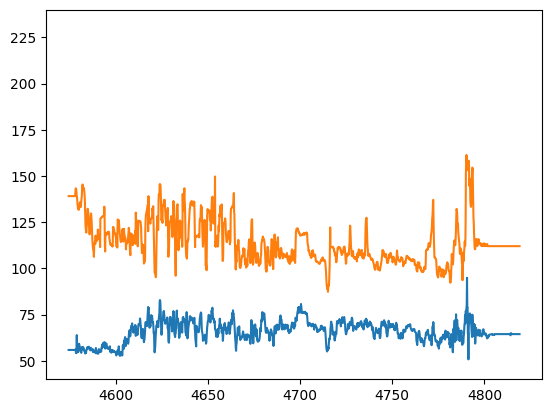

In [ ]:
plt.plot(depth, dtco)
plt.plot(depth, dtsm)
plt.ylim(40, 240)

### Plotting the Semblance Map

We will start with setting up a subplot with two axes and using `subplot2grid`. The first axis will contain the semblance plot and the second will be twinned with the first. This allows the data to be plotted on the same y-axis.

To plot the semblance data we need to use `imshow`. When we do this, we need to pass in the extent of the array both in terms of depth range (using `depth.min() and depth.max()`) and the data range (40 - 240 us/ft).

On top of that, the DTCO and DTSM curves can be plotted. This allows us to see how these curves were picked from the semblance map.



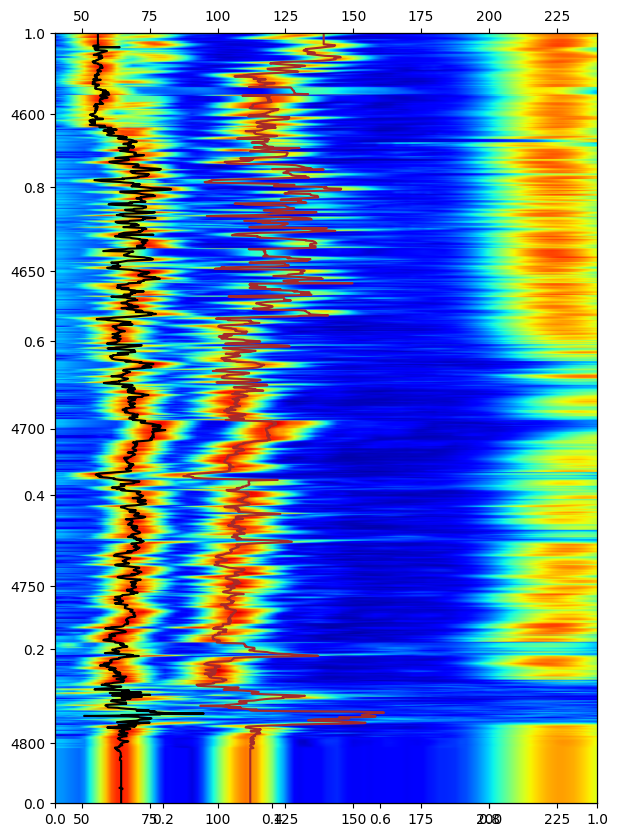

In [ ]:
fig, axes = plt.subplots(figsize=(7,10))

ax1 = plt.subplot2grid((1, 1), (0,0))
ax2 = ax1.twiny()

ax1.imshow(stc_mono, interpolation='bilinear', aspect='auto',
          cmap=plt.cm.jet, vmin=0, vmax=100,
           extent=[40, 240, depth.min(), depth.max()])

#Setting up the display depth range. Note that the
# depths need to be deepest first and shallowest second
ax1.set_ylim(depth.max(), depth.min())

ax2.plot(dtco, depth, color='black')
ax2.plot(dtsm, depth, color='brown')

ax2.set_xlim(40, 240)

plt.show()

### Plotting the Processed Waveform Data

We can modify the plot to add in a subplot for the acoustic waveform data associated with the semblance map. If we look at the shape of wf_mono we can see it returns (1606, 8, 512). This indicates that the array is multi-dimensional. The middle number indicates that we have 8 receivers worth of data.

In [ ]:
wf_mono.shape

(1606, 8, 512)

To access the first receiver, which is usually the closest one to the transmitter array, we can create a slice of the data like so:

In [ ]:
wf_r1 = wf_mono[:, 0, :]
print(wf_r1.min())
print(wf_r1.max())

-8192
8188


This code returns the minimum and maximum values of the array, which can be used as a guide for scaling colours.

Taking the plot code from the semblance map section, we can enhance it by adding another subplot. In this subplot, we will use another `imshow()` plot and pass in the relevant parameters. The `vmin` and `vmax` parameters can be used to tweak the image to bring out or reduce the detail within the waveform.

NameError: name 'wf_r1' is not defined

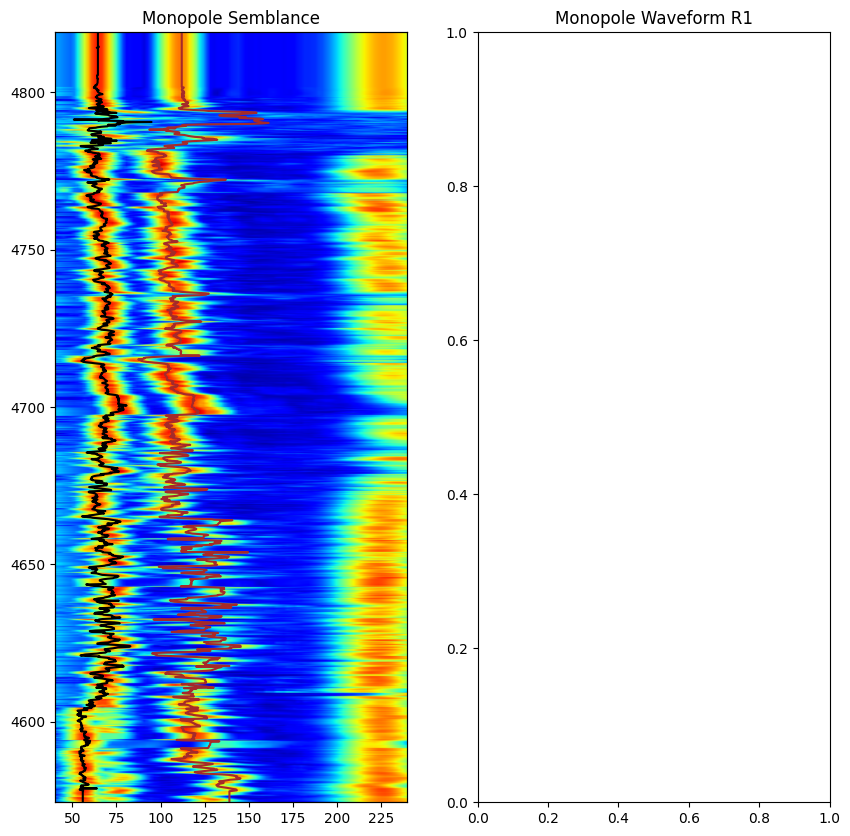

In [ ]:
import matplotlib.pyplot as plt
from dlisio import dlis

f, *tail = dlis.load('Data/NLOG_LIS_LAS_7857_FMS_DSI_MAIN_LOG.DLIS')
frame1 = f.object('FRAME','60B')
curves = frame1.curves()
depth = curves['TDEP'] * 0.00254

import matplotlib.pyplot as plt

# Create figure and define subplot layout
fig = plt.figure(figsize=(10, 10))

# Subplot for semblance map
ax1 = plt.subplot2grid((1, 2), (0, 0))

# Share x-axis for curves
ax2 = ax1.twiny()

# Subplot for waveform
ax3 = plt.subplot2grid((1, 2), (0, 1))

# ✅ Convert to tuple of floats explicitly
extent_semblance = (40.0, 240.0, float(depth.min()), float(depth.max()))
extent_waveform = (0.0, 3000.0, float(depth.min()), float(depth.max()))

# ✅ Use valid colormap names as strings
ax1.imshow(stc_mono, interpolation='bilinear', aspect='auto',
           cmap='jet', vmin=0, vmax=100, extent=extent_semblance)
ax1.set_title('Monopole Semblance')

ax2.plot(dtco, depth, color='black', label='DTC')
ax2.plot(dtsm, depth, color='brown', label='DTS')
ax2.set_xlim(40, 240)
ax2.set_xticks([])

ax3.set_title('Monopole Waveform R1')
ax3.imshow(wf_r1, interpolation='bilinear', aspect='auto',
           cmap='seismic', vmin=-2000, vmax=2000, extent=extent_waveform)
ax3.set_xlim(0, 1000)

# Flip y-axis to go top-down with depth
for ax in [ax1, ax2, ax3]:
    ax.set_ylim(float(depth.max()), float(depth.min()))

### Adding Interactive Controls

Rather than rerunning the cell each time the depth and/or DT plot scales require changing, we can add a few interactive widgets to help with this. This can be achieved by importing `ipywidgets` and `IPython.display`. 
The plot code can be placed inside a function and decorated with the widgets code. In the example below, we are passing in MinDepth, MaxDepth, MinDT and MaxDT. All four of which can be called upon in the code.

In [ ]:
%pip install ipywidgets

import ipywidgets as widgets
from IPython.display import display

# Add the widgets decorator and setup the interactive variables
@widgets.interact(MinDepth=(depth.min(),depth.max(), 10), 
                  MaxDepth=(depth.min(),depth.max(), 10),
                 MinDT=(40, 240, 5),
                 MaxDT=(40, 240, 5))
def acoustic_plot(MinDepth=depth.min(), MaxDepth=depth.max(),
                 MinDT=40, MaxDT=240):
    fig = plt.subplots(figsize=(10,10))

    # Subplot for the semblance map
    ax1 = plt.subplot2grid((1, 2), (0,0))

    # Subplot for the DTC and DTS curves
    ax2 = ax1.twiny()

    # Subplot for the waveform data
    ax3 = plt.subplot2grid((1, 2), (0,1))

    ax1.imshow(stc_mono, interpolation='bilinear', aspect='auto',
              cmap=plt.cm.jet, vmin=0, vmax=100,
               extent=[40, 240, depth.min(), depth.max()])
    ax1.set_xlim(MinDT, MaxDT)
    ax1.set_title('Monopole Semblance')

    ax2.plot(dtco, depth, color='black')
    ax2.set_xlim(MinDT, MaxDT)
    ax2.set_xticks([])

    ax2.plot(dtco, depth, color='black')
    ax2.plot(dtsm, depth, color='brown')

    ax3.set_title('Monopole Waveform R1')
    ax3.imshow(wf_r1, interpolation='bilinear', aspect='auto',
              cmap=plt.cm.seismic, vmin=-2000, vmax=2000,
               extent=[0, 3000, depth.min(), depth.max()])

    ax3.set_xlim(0, 1000)


    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(MaxDepth, MinDepth)

Note: you may need to restart the kernel to use updated packages.


## Summary
In this article, we have covered how to load a DLIS file using the DLISIO Python library. Once the DLIS file is loaded, different parameter tables and logging curves can be viewed and extracted. We have also seen how we can take processed acoustic waveform data and plot it using matplotlib. DLIS files don't have to be daunting to work with in Python. Once the basic structure and commands from DLISIO are understood it becomes much simpler.



***Thanks for reading!***

*If you have found this article useful, please feel free to check out my other articles looking at various aspects of Python and well log data. You can also find my code used in this article and others at [GitHub](https://github.com/andymcdgeo).*

*If you want to get in touch you can find me on [LinkedIn](https://www.linkedin.com/in/andymcdonaldgeo/) or at my [website](http://andymcdonald.scot/).*

*Interested in learning more about python and well log data or petrophysics? Follow me on [Medium](https://medium.com/@andymcdonaldgeo).*

## References

[Viggen, E.M. Extracing data from DLIS Files](https://erlend-viggen.no/dlis-files/)  
[Viggen, E.M, Harstad, E., and Kvalsvik J. (2020), Getting started with acoustic well log data using the dlisio Python library on the Volve Data Village dataset](https://www.researchgate.net/publication/340645995_Getting_started_with_acoustic_well_log_data_using_the_dlisio_Python_library_on_the_Volve_Data_Village_dataset)

[NLOG: Dutch Oil and Gas Portal](https://www.nlog.nl/en/welcome-nlog)
